In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- paths ---
base_dir = Path.home() / "Desktop" / "rbi-lite"
params_path = base_dir / "data" / "params.json"
inspection_csv = base_dir / "data" / "inspection_data.csv"
fig_dir = base_dir / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# --- load params ---
with open(params_path, "r", encoding="utf-8") as f:
    params = json.load(f)

t0 = float(params["t0_mm"])
t_min = float(params["t_min_mm"])
r_mean = float(params["r_mean_mm_per_year"])
r_std = float(params["r_std_mm_per_year"])
meas_std_default = float(params["meas_std_mm"])
horizon_years = int(params["horizon_years"])
n_mc = int(params.get("n_mc", 20000))

# --- load inspection data ---
insp = pd.read_csv(inspection_csv)

insp

,inspection_id,time_years,thickness_measured_mm,meas_std_mm
0,1,1.0,11.373723,0.2
1,2,2.5,10.875786,0.2
2,3,4.0,9.827916,0.2


In [2]:
required_cols = {"time_years", "thickness_measured_mm"}
missing = required_cols - set(insp.columns)
if missing:
    raise ValueError(f"Kolom hilang di inspection_data.csv: {missing}")

# kalau meas_std_mm tidak ada, kita pakai default dari params.json
if "meas_std_mm" not in insp.columns:
    insp["meas_std_mm"] = meas_std_default

insp

,inspection_id,time_years,thickness_measured_mm,meas_std_mm
0,1,1.0,11.373723,0.2
1,2,2.5,10.875786,0.2
2,3,4.0,9.827916,0.2


In [3]:
r_max = max(2.0, r_mean + 6*r_std)  # batas atas aman
r_grid = np.linspace(0.0, r_max, 2000)  # 2000 titik kandidat

r_grid[:5], r_grid[-5:], r_max

(array([0.        , 0.00115058, 0.00230115, 0.00345173, 0.0046023 ]),
 array([2.2953977 , 2.29654827, 2.29769885, 2.29884942, 2.3       ]),
 2.3)

In [4]:
# prior: Normal(r_mean, r_std) lalu dipotong r>=0 (truncate sederhana)
prior_pdf = norm.pdf(r_grid, loc=r_mean, scale=r_std)

# karena r tidak boleh negatif, grid kita sudah mulai dari 0
# normalisasi prior supaya total area = 1
prior_pdf = prior_pdf / np.trapezoid(prior_pdf, r_grid)
np.trapezoid(prior_pdf, r_grid)

np.float64(1.0)

In [5]:
times = insp["time_years"].to_numpy(dtype=float)
t_meas = insp["thickness_measured_mm"].to_numpy(dtype=float)
meas_std = insp["meas_std_mm"].to_numpy(dtype=float)

# prediksi ketebalan untuk semua r_grid dan semua time:
# shape: (len(r_grid), len(times))
t_pred = t0 - np.outer(r_grid, times)

# likelihood tiap titik data: Normal(t_meas | mean=t_pred, std=meas_std)
# kita hitung log-likelihood biar tidak underflow (angka jadi super kecil)
log_like = np.zeros(len(r_grid))

for i in range(len(times)):
    log_like += norm.logpdf(t_meas[i], loc=t_pred[:, i], scale=meas_std[i])

log_like[:5], log_like.shape

(array([-77.60385322, -77.25546558, -76.90784742, -76.56099873,
        -76.21491951]),
 (2000,))

In [6]:
# posterior ∝ prior * likelihood
# gunakan log untuk stabil: log posterior = log prior + log_like
log_prior = np.log(prior_pdf + 1e-300)  # tambah kecil supaya tidak log(0)
log_posterior_unnorm = log_prior + log_like

# shift untuk stabilitas numerik
log_posterior_unnorm -= np.max(log_posterior_unnorm)

posterior_unnorm = np.exp(log_posterior_unnorm)

# normalisasi posterior supaya luas = 1
posterior_pdf = posterior_unnorm / np.trapezoid(posterior_unnorm, r_grid)

np.trapezoid(posterior_pdf, r_grid)

np.float64(1.0)

In [7]:
# mean posterior (ekspektasi)
r_post_mean = np.trapezoid(r_grid * posterior_pdf, r_grid)

# hitung quantile (mis. 5% dan 95%) dengan CDF diskrit
cdf = np.cumsum(posterior_pdf)
cdf = cdf / cdf[-1]

def quantile_from_grid(q):
    idx = np.searchsorted(cdf, q)
    return r_grid[min(idx, len(r_grid)-1)]

r_p05 = quantile_from_grid(0.05)
r_p95 = quantile_from_grid(0.95)

print(f"Prior mean r = {r_mean:.3f} mm/yr (std {r_std:.3f})")
print(f"Posterior mean r ≈ {r_post_mean:.3f} mm/yr")
print(f"Posterior 90% interval ≈ [{r_p05:.3f}, {r_p95:.3f}] mm/yr")

Prior mean r = 0.800 mm/yr (std 0.250)
Posterior mean r ≈ 0.529 mm/yr
Posterior 90% interval ≈ [0.461, 0.596] mm/yr


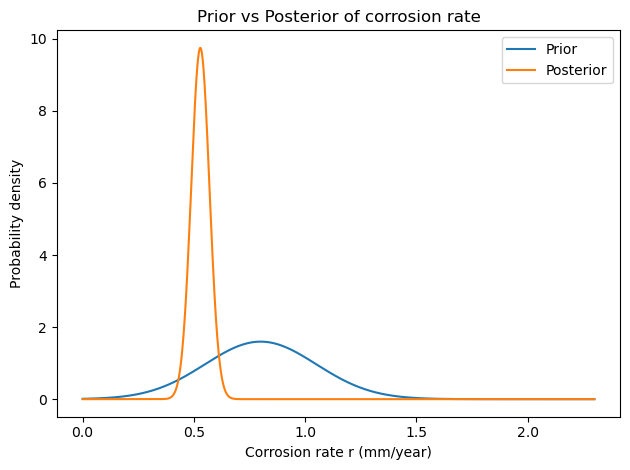

Saved: C:\Users\LENOVO\Desktop\rbi-lite\figures\step4_prior_vs_posterior_r.png


In [8]:
plt.figure()
plt.plot(r_grid, prior_pdf, label="Prior")
plt.plot(r_grid, posterior_pdf, label="Posterior")
plt.xlabel("Corrosion rate r (mm/year)")
plt.ylabel("Probability density")
plt.title("Prior vs Posterior of corrosion rate")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "step4_prior_vs_posterior_r.png", dpi=200)
plt.show()

print("Saved:", fig_dir / "step4_prior_vs_posterior_r.png")

In [9]:
dt_year = 1/12
time_years = np.arange(0, horizon_years + dt_year, dt_year)

In [10]:
rng = np.random.default_rng(42)

# sample r dari prior (Normal, clip ke >=0)
r_prior_samples = rng.normal(loc=r_mean, scale=r_std, size=n_mc)
r_prior_samples = np.clip(r_prior_samples, 0.0, None)

th_prior = t0 - np.outer(r_prior_samples, time_years)
pof_prior = (th_prior < t_min).mean(axis=0)

In [11]:
# buat probabilitas diskrit untuk sampling grid
p_grid = posterior_pdf / posterior_pdf.sum()

# sample indeks grid sesuai distribusi posterior
idx = rng.choice(len(r_grid), size=n_mc, replace=True, p=p_grid)
r_post_samples = r_grid[idx]

th_post = t0 - np.outer(r_post_samples, time_years)
pof_post = (th_post < t_min).mean(axis=0)

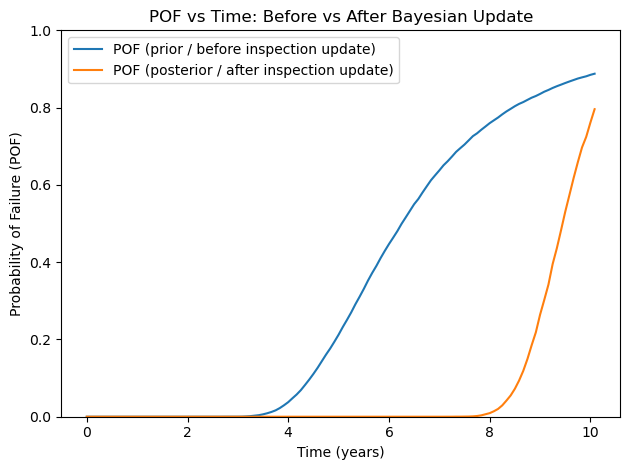

Saved: C:\Users\LENOVO\Desktop\rbi-lite\figures\step4_pof_before_vs_after.png


In [12]:
plt.figure()
plt.plot(time_years, pof_prior, label="POF (prior / before inspection update)")
plt.plot(time_years, pof_post, label="POF (posterior / after inspection update)")
plt.xlabel("Time (years)")
plt.ylabel("Probability of Failure (POF)")
plt.title("POF vs Time: Before vs After Bayesian Update")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "step4_pof_before_vs_after.png", dpi=200)
plt.show()

print("Saved:", fig_dir / "step4_pof_before_vs_after.png")

In [13]:
# di akhir Step 4, tambahkan:
pd.DataFrame({"r_grid": r_grid, "posterior_pdf": posterior_pdf}).to_csv(
    base_dir / "data" / "posterior_grid.csv", index=False
)